In [0]:
# installs
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision

In [0]:
# imports 
import torch
import torchvision
import numpy as np 
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from IPython import display
import time

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [0]:
def f(x):                # logistic function activation (replace to define your own activation function)
    return torch.tanh(x)
def df(y):               # derivative of f composed with inverse of f
    return 1 - y*y

n0 = 784                 # widths of layers
n1 = 200
n2 = 100
n3 = 10  

eta = 0.01               # learning rate parameter
epsinit = 0.01           # magnitude of initial conditions for synaptic weights

# two fully connected synaptic layers
W1 = epsinit*torch.randn(n1,n0)
W2 = epsinit*torch.randn(n2,n1)
W3 = epsinit*torch.randn(n3,n2)

# biases
b1 = epsinit*torch.randn(n1, 1)
b2 = epsinit*torch.randn(n2, 1)
b3 = epsinit*torch.randn(n3, 1)

tmax = 600000             # maximum number of learning updates
tshow = 1000              # how often to pause for visualization
errsq = torch.zeros(tmax)
errcl = torch.zeros(tmax)
errclvalidate = torch.zeros(int(tmax / tshow))

In [0]:
# get data
mnist = torchvision.datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.train_data
trainlabels = mnist.train_labels

# preprocess training set
trainimages = trainimages.float()/255.0

# separate out validation set
mtotal = len(trainimages)       # number of examples in training set
mvalidate = 10000               # desired size of validation set
mtrain = mtotal - mvalidate     # remaining examples will be the new training set
np.random.seed(495)             # seed the random number generator so that validation set is reproducible
ind = np.random.permutation(range(mtotal))
validate = [trainimages[i] for i in ind[:mvalidate]]
validatelabels = [trainlabels[i] for i in ind[:mvalidate]]
train = [trainimages[i] for i in ind[mvalidate:]]
trainlabels = [trainlabels[i] for i in ind[mvalidate:]]

batchsize = 32     # minibatch size

In [33]:
trainlabels[0:10]

[8, 9, 4, 1, 0, 5, 7, 2, 1, 4]

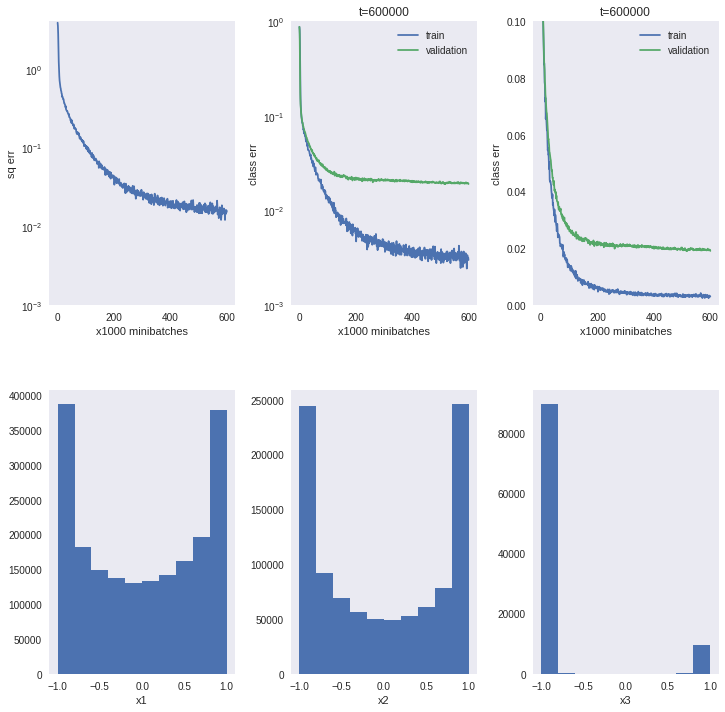

In [5]:
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
fig_size = (12,12)                           # you may need to change the numbers to fit your screen

for t in range(tmax):
    # generate random samples from train set
    batchindices = [int(np.floor(mtrain * np.random.rand())) for i in range(batchsize)] 
    x0 = torch.zeros(n0, batchsize)
    for i, j in zip(range(batchsize), batchindices):
        x0[:, i] = train[j]
    
    y = -torch.ones(n3, batchsize)
    for i, j in zip(range(batchsize), batchindices):
        y[int(trainlabels[j]), i] = 1.0
    
    B1 = b1.repeat(1, batchsize).view(n1, batchsize)
    B2 = b2.repeat(1, batchsize).view(n2, batchsize)
    B3 = b3.repeat(1, batchsize).view(n3, batchsize)
 
    # forward pass   
    x1 = f(torch.mm(W1,x0)+B1)
    x2 = f(torch.mm(W2,x1)+B2)
    x3 = f(torch.mm(W3,x2)+B3)
    
    # error computation
    errsq[t] = sum(sum(torch.pow((y-x3), 2))) / batchsize
    errcl[t] = sum([float(np.argmax(x3[:, i]) != int(trainlabels[j])) for i, j in zip(range(batchsize), batchindices)]) / batchsize
    delta3 = (y-x3)*df(x3)

    # backward pass
    delta2 = torch.mm(W3.transpose(1,0), delta3)*df(x2)
    delta1 = torch.mm(W2.transpose(1,0), delta2)*df(x1)
 
    # learning updates
    W3 += eta / batchsize * torch.mm(delta3, x2.transpose(1,0))
    W2 += eta / batchsize * torch.mm(delta2, x1.transpose(1,0))
    W1 += eta / batchsize * torch.mm(delta1, x0.transpose(1,0))
    b3 += eta / batchsize * torch.sum(delta3, dim=1).view(n3, 1)
    b2 += eta / batchsize * torch.sum(delta2, dim=1).view(n2, 1)
    b1 += eta / batchsize * torch.sum(delta1, dim=1).view(n1, 1)

    if (t + 1) % tshow == 0:    # visualization every tshow steps
        avgerrsq = torch.sum(errsq[: (t + 1)].view(int((t + 1) / tshow), tshow), dim=1).view(int((t + 1) / tshow), 1) / tshow
        avgerrcl = torch.sum(errcl[: (t + 1)].view(int((t + 1) / tshow), tshow), dim=1).view(int((t + 1) / tshow), 1) / tshow
        
        # compute error on validation set
        x0 = torch.zeros(n0, mvalidate)
        for i in range(mvalidate):
            x0[:, i] = validate[i].view(784)
        B1 = b1.repeat(1, mvalidate).view(n1, mvalidate)
        B2 = b2.repeat(1, mvalidate).view(n2, mvalidate)
        B3 = b3.repeat(1, mvalidate).view(n3, mvalidate)
 
        x1 = f(torch.mm(W1,x0)+B1)
        x2 = f(torch.mm(W2,x1)+B2)
        x3 = f(torch.mm(W3,x2)+B3)
  
        errclvalidate[int((t + 1) / tshow - 1)] = sum([float(np.argmax(x3[:, i]) != int(validatelabels[i])) for i in range(mvalidate)]) / mvalidate
        
        # plot figures
        fig = plt.figure(figsize=fig_size)
        gs = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.3)

        ax = fig.add_subplot(gs[0,0])
        ax.plot(range(1, int((t + 1) / tshow) + 1), avgerrsq.numpy(), label="squared")
        ax.set_ylabel("sq err")
        ax.set_ylim([0.001,4])
        ax.set_yscale('log')
        ax.set_xlabel("x{} minibatches".format(tshow))
        ax.grid()
        
        ax = fig.add_subplot(gs[0,1])
        ax.plot(range(1, int((t + 1) / tshow) + 1), avgerrcl.numpy(), label="train")
        ax.plot(range(1, int((t + 1) / tshow) + 1), errclvalidate[: int((t + 1) / tshow)].numpy(), label="validation")
        ax.set_ylabel("class err")
        ax.set_ylim([0.001,1])
        ax.set_yscale('log')
        ax.set_title("t={}".format(t + 1))
        ax.set_xlabel("x{} minibatches".format(tshow))
        ax.grid()
        ax.legend()
        
        ax = fig.add_subplot(gs[0,2])
        ax.plot(range(1, int((t + 1) / tshow) + 1), avgerrcl.numpy(), label="train")
        ax.plot(range(1, int((t + 1) / tshow) + 1), errclvalidate[: int((t + 1) / tshow)].numpy(), label="validation")
        ax.set_ylabel("class err")
        ax.set_ylim([0.0, 0.1])
        ax.set_title("t={}".format(t + 1))
        ax.set_xlabel("x{} minibatches".format(tshow))
        ax.grid()
        ax.legend()
        
        ax = fig.add_subplot(gs[1, 0])
        ax.hist(x1.view(-1))
        ax.set_xlabel("x1")
        ax.grid()
        
        ax = fig.add_subplot(gs[1, 1])
        ax.hist(x2.view(-1))
        ax.set_xlabel("x2")
        ax.grid()
        
        ax = fig.add_subplot(gs[1, 2])
        ax.hist(x3.view(-1))
        ax.set_xlabel("x3")
        ax.grid()

        display.display(plt.gcf())
        time.sleep(0.01)
        display.clear_output(wait=True)
        fig.clf()
        plt.close(fig)

### **The above shows the results of : **
1.   eta = 0.01
2.   episint = 0.01

**The final results: **

1.   Training error: 0.0022
2.   Validation error: 0.022




## **Switch to logistic function: **

In [0]:
def f(x):
    return 1 / (1+torch.exp(-x))
def df(y):
    return y * (1-y)

n0 = 784                 # widths of layers
n1 = 200
n2 = 100
n3 = 10  

eta = 0.3               # learning rate parameter
epsinit = 0.01           # magnitude of initial conditions for synaptic weights

# two fully connected synaptic layers
W1 = epsinit*torch.randn(n1,n0)
W2 = epsinit*torch.randn(n2,n1)
W3 = epsinit*torch.randn(n3,n2)

# biases
b1 = epsinit*torch.randn(n1, 1)
b2 = epsinit*torch.randn(n2, 1)
b3 = epsinit*torch.randn(n3, 1)

tmax = 600000             # maximum number of learning updates
tshow = 1000              # how often to pause for visualization
errsq = torch.zeros(tmax)
errcl = torch.zeros(tmax)
errclvalidate = torch.zeros(int(tmax / tshow))

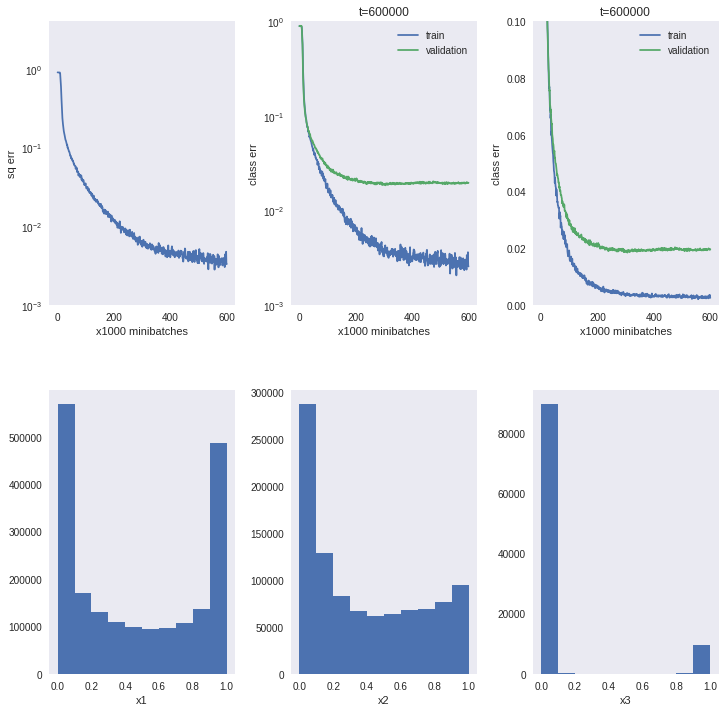

In [47]:
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'
fig_size = (12,12)                           # you may need to change the numbers to fit your screen

for t in range(tmax):
    # generate random samples from train set
    batchindices = [int(np.floor(mtrain * np.random.rand())) for i in range(batchsize)] 
    x0 = torch.zeros(n0, batchsize)
    for i, j in zip(range(batchsize), batchindices):
        x0[:, i] = train[j]
    
    y = torch.zeros(n3, batchsize)
    for i, j in zip(range(batchsize), batchindices):
        y[int(trainlabels[j]), i] = 1.0
    
    B1 = b1.repeat(1, batchsize).view(n1, batchsize)
    B2 = b2.repeat(1, batchsize).view(n2, batchsize)
    B3 = b3.repeat(1, batchsize).view(n3, batchsize)
 
    # forward pass   
    x1 = f(torch.mm(W1,x0)+B1)
    x2 = f(torch.mm(W2,x1)+B2)
    x3 = f(torch.mm(W3,x2)+B3)
    
    # error computation
    errsq[t] = sum(sum(torch.pow((y-x3), 2))) / batchsize
    errcl[t] = sum([float(np.argmax(x3[:, i]) != int(trainlabels[j])) for i, j in zip(range(batchsize), batchindices)]) / batchsize
    delta3 = (y-x3)*df(x3)

    # backward pass
    delta2 = torch.mm(W3.transpose(1,0), delta3)*df(x2)
    delta1 = torch.mm(W2.transpose(1,0), delta2)*df(x1)
 
    # learning updates
    W3 += eta / batchsize * torch.mm(delta3, x2.transpose(1,0))
    W2 += eta / batchsize * torch.mm(delta2, x1.transpose(1,0))
    W1 += eta / batchsize * torch.mm(delta1, x0.transpose(1,0))
    b3 += eta / batchsize * torch.sum(delta3, dim=1).view(n3, 1)
    b2 += eta / batchsize * torch.sum(delta2, dim=1).view(n2, 1)
    b1 += eta / batchsize * torch.sum(delta1, dim=1).view(n1, 1)

    if (t + 1) % tshow == 0:    # visualization every tshow steps
        avgerrsq = torch.sum(errsq[: (t + 1)].view(int((t + 1) / tshow), tshow), dim=1).view(int((t + 1) / tshow), 1) / tshow
        avgerrcl = torch.sum(errcl[: (t + 1)].view(int((t + 1) / tshow), tshow), dim=1).view(int((t + 1) / tshow), 1) / tshow
        
        
        # compute error on validation set
        x0 = torch.zeros(n0, mvalidate)
        for i in range(mvalidate):
            x0[:, i] = validate[i].view(784)
        B1 = b1.repeat(1, mvalidate).view(n1, mvalidate)
        B2 = b2.repeat(1, mvalidate).view(n2, mvalidate)
        B3 = b3.repeat(1, mvalidate).view(n3, mvalidate)
 
        x1 = f(torch.mm(W1,x0)+B1)
        x2 = f(torch.mm(W2,x1)+B2)
        x3 = f(torch.mm(W3,x2)+B3)
  
        errclvalidate[int((t + 1) / tshow - 1)] = sum([float(np.argmax(x3[:, i]) != int(validatelabels[i])) for i in range(mvalidate)]) / mvalidate
        
        # plot figures
        fig = plt.figure(figsize=fig_size)
        gs = gridspec.GridSpec(2, 3, wspace=0.3, hspace=0.3)

        ax = fig.add_subplot(gs[0,0])
        ax.plot(range(1, int((t + 1) / tshow) + 1), avgerrsq.numpy(), label="squared")
        ax.set_ylabel("sq err")
        ax.set_ylim([0.001,4])
        ax.set_yscale('log')
        ax.set_xlabel("x{} minibatches".format(tshow))
        ax.grid()
        
        ax = fig.add_subplot(gs[0,1])
        ax.plot(range(1, int((t + 1) / tshow) + 1), avgerrcl.numpy(), label="train")
        ax.plot(range(1, int((t + 1) / tshow) + 1), errclvalidate[: int((t + 1) / tshow)].numpy(), label="validation")
        ax.set_ylabel("class err")
        ax.set_ylim([0.001,1])
        ax.set_yscale('log')
        ax.set_title("t={}".format(t + 1))
        ax.set_xlabel("x{} minibatches".format(tshow))
        ax.grid()
        ax.legend()
        
        ax = fig.add_subplot(gs[0,2])
        ax.plot(range(1, int((t + 1) / tshow) + 1), avgerrcl.numpy(), label="train")
        ax.plot(range(1, int((t + 1) / tshow) + 1), errclvalidate[: int((t + 1) / tshow)].numpy(), label="validation")
        ax.set_ylabel("class err")
        ax.set_ylim([0.0, 0.1])
        ax.set_title("t={}".format(t + 1))
        ax.set_xlabel("x{} minibatches".format(tshow))
        ax.grid()
        ax.legend()
        
        ax = fig.add_subplot(gs[1, 0])
        ax.hist(x1.view(-1))
        ax.set_xlabel("x1")
        ax.grid()
        
        ax = fig.add_subplot(gs[1, 1])
        ax.hist(x2.view(-1))
        ax.set_xlabel("x2")
        ax.grid()
        
        ax = fig.add_subplot(gs[1, 2])
        ax.hist(x3.view(-1))
        ax.set_xlabel("x3")
        ax.grid()

        display.display(plt.gcf())
        time.sleep(0.01)
        display.clear_output(wait=True)
        fig.clf()
        plt.close(fig)